In [4]:
import numpy as np
from numpy.random import binomial

In [5]:
from dataclasses import dataclass

In [3]:
# pip install virtualenvwrapper

In [2]:
import sys
sys.path
sys.path.append('/Users/mulingsi/Desktop/MSE346/RL-book/')

In [3]:
from typing import Optional, Mapping, Sequence, Tuple
from collections import Counter
import itertools
from operator import itemgetter
from rl.gen_utils.common_funcs import get_logistic_func, get_unit_sigmoid_func

# Process 1

In [6]:
@dataclass
class Process1: 
    @dataclass
    class State: 
        # define the state variable, X_t, integer
        price: int
            
    level_param: int # level to which price mean-reverts (L)
    alpha1: float = 0.25 # strength of mean-reversion (non-negative value)
    def up_prob(self, state: State) -> float:
        return 1. / (1 + np.exp(-self.alpha1 * (self.level_param - state.price)))
    def next_state(self, state: State) -> State:
        up_move: int = np.random.binomial(1, self.up_prob(state), 1)[0] 
        return Process1.State(price=state.price + up_move * 2 - 1)

In [37]:
# np.random.binomial(1, 0.5, 1)

In [8]:
def simulation(process, start_state): 
    state = start_state
    while True:
        yield state
        state = process.next_state(state)

In [9]:
def process1_price_traces( start_price: int, 
                          level_param: int, 
                          alpha1: float, 
                          time_steps: int, 
                          num_traces: int
) -> np.ndarray:
    process = Process1(level_param=level_param, alpha1=alpha1) 
    start_state = Process1.State(price=start_price)
    return np.vstack([
        #np.fromiter & itertools.islice function
        np.fromiter((s.price for s in itertools.islice( 
            simulation(process, start_state), 
            time_steps + 1
        )), float) for _ in range(num_traces)])

In [52]:
# itertools.islice??

# process = Process1(level_param=level_param, alpha1=alpha1) 
# start_state = Process1.State(price=start_price)

# [s.price for s in itertools.islice( 
#             simulation(process, start_state), 
#             time_steps + 1
#         )]

In [54]:
from rl.gen_utils.plot_funcs import plot_list_of_curves

In [77]:
process1_traces: np.ndarray = process1_price_traces(
    start_price=100,
    level_param=100,
    alpha1=1,
    time_steps=100,
    num_traces=3
    )

In [78]:
len(process1_traces[0])

101

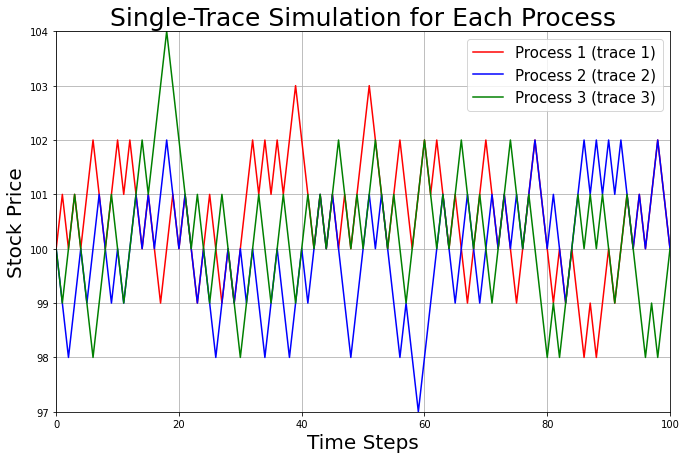

In [79]:
traces_len = len(process1_traces[0])
plot_list_of_curves(
        [range(traces_len)] * 3,
        [process1_traces[0], process1_traces[1], process1_traces[2]],
        ["r", "b", "g"],
        [
            r"Process 1 (trace 1)",
            r"Process 2 (trace 2)",
            r"Process 3 (trace 3)"
        ],
        "Time Steps",
        "Stock Price",
        "Single-Trace Simulation for Each Process"
    )

# Process 2

In [33]:
handy_map: Mapping[Optional[bool], int] = {True: -1, False: 1, None: 0}

In [24]:
@dataclass
class Process2:
    @dataclass
    class State:
        price: int
        is_prev_move_up: Optional[bool]

    alpha2: float = 0.75  # strength of reverse-pull (value in [0,1])

    def up_prob(self, state: State) -> float:
        return 0.5 * (1 + self.alpha2 * handy_map[state.is_prev_move_up])

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process2.State(
            price=state.price + up_move * 2 - 1,
            is_prev_move_up=bool(up_move)
        )

# Process 3

In [ ]:
@dataclass
class Process3:
    @dataclass
    class State:
        num_up_moves: int
        num_down_moves: int

    alpha3: float = 1.0  # strength of reverse-pull (non-negative value)

    def up_prob(self, state: State) -> float:
        total = state.num_up_moves + state.num_down_moves
        return get_unit_sigmoid_func(self.alpha3)(
            state.num_down_moves / total
        ) if total else 0.5

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process3.State(
            num_up_moves=state.num_up_moves + up_move,
            num_down_moves=state.num_down_moves + 1 - up_move
        )


def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)


def process1_price_traces(
    start_price: int,
    level_param: int,
    alpha1: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process1(level_param=level_param, alpha1=alpha1)
    start_state = Process1.State(price=start_price)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)])


def process2_price_traces(
    start_price: int,
    alpha2: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process2(alpha2=alpha2)
    start_state = Process2.State(price=start_price, is_prev_move_up=None)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)])


def process3_price_traces(
    start_price: int,
    alpha3: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process3(alpha3=alpha3)
    start_state = Process3.State(num_up_moves=0, num_down_moves=0)
    return np.vstack([
        np.fromiter((start_price + s.num_up_moves - s.num_down_moves
                    for s in itertools.islice(simulation(process, start_state),
                                              time_steps + 1)), float)
        for _ in range(num_traces)])

# Helper functions 

In [26]:
def plot_single_trace_all_processes(
    process1_trace: np.ndarray,
    process2_trace: np.ndarray,
    process3_trace: np.ndarray
) -> None:

    from rl.gen_utils.plot_funcs import plot_list_of_curves

    traces_len = len(process1_trace)

    plot_list_of_curves(
        [range(traces_len)] * 3,
        [process1_trace, process2_trace, process3_trace],
        ["r", "b", "g"],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Time Steps",
        "Stock Price",
        "Single-Trace Simulation for Each Process"
    )


def get_terminal_histogram(
    price_traces: np.ndarray
) -> Tuple[Sequence[int], Sequence[int]]:
    pairs = sorted(
        list(Counter(price_traces[:, -1]).items()),
        key=itemgetter(0)
    )
    return [x for x, _ in pairs], [y for _, y in pairs]


def plot_distribution_at_time_all_processes(
    process1_traces: np.ndarray,
    process2_traces: np.ndarray,
    process3_traces: np.ndarray
) -> None:

    from rl.gen_utils.plot_funcs import plot_list_of_curves

    num_traces = len(process1_traces)
    time_steps = len(process1_traces[0]) - 1

    x1, y1 = get_terminal_histogram(process1_traces)
    x2, y2 = get_terminal_histogram(process2_traces)
    x3, y3 = get_terminal_histogram(process3_traces)

    plot_list_of_curves(
        [x1, x2, x3],
        [y1, y2, y3],
        ["r", "b", "g"],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Terminal Stock Price",
        "Counts",
        f"Terminal Price Counts (T={time_steps:d}, Traces={num_traces:d})"
    )

# Run simulations

In [29]:
start_price: int = 100
level_param: int = 100
alpha1: float = 0.25
alpha2: float = 0.75
alpha3: float = 1.0
time_steps: int = 100
num_traces: int = 1000

In [30]:
process1_traces: np.ndarray = process1_price_traces(
    start_price=start_price,
    level_param=level_param,
    alpha1=alpha1,
    time_steps=time_steps,
    num_traces=num_traces
    )

In [31]:
# process1_traces[999]

In [34]:
process2_traces: np.ndarray = process2_price_traces(
        start_price=start_price,
        alpha2=alpha2,
        time_steps=time_steps,
        num_traces=num_traces
    )
process3_traces: np.ndarray = process3_price_traces(
        start_price=start_price,
        alpha3=alpha3,
        time_steps=time_steps,
        num_traces=num_traces
    )

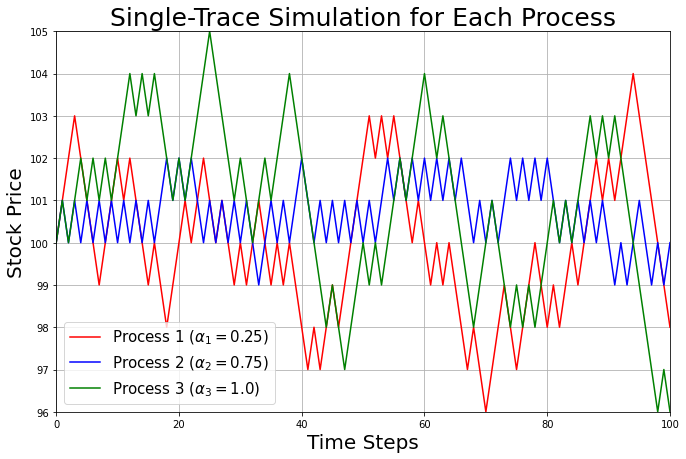

In [35]:
trace1 = process1_traces[0]
trace2 = process2_traces[0]
trace3 = process3_traces[0]

plot_single_trace_all_processes(trace1, trace2, trace3)

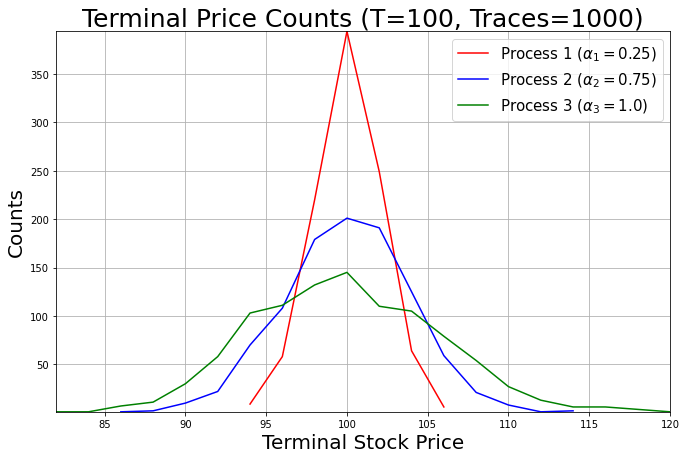

In [36]:
plot_distribution_at_time_all_processes(
        process1_traces,
        process2_traces,
        process3_traces
    )

# Inventory example 

In [6]:
from dataclasses import dataclass
from typing import Mapping, Dict
from rl.distribution import Categorical
from rl.markov_process import Transition, FiniteMarkovProcess
from scipy.stats import poisson


@dataclass(frozen=True)
class InventoryState:
    on_hand: int
    on_order: int

    def inventory_position(self) -> int:
        return self.on_hand + self.on_order


class SimpleInventoryMPFinite(FiniteMarkovProcess[InventoryState]):

    def __init__(
        self,
        capacity: int,
        poisson_lambda: float
    ):
        self.capacity: int = capacity
        self.poisson_lambda: float = poisson_lambda

        self.poisson_distr = poisson(poisson_lambda)
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Transition[InventoryState]:
        d: Dict[InventoryState, Categorical[InventoryState]] = {}
        for alpha in range(self.capacity + 1):
            for beta in range(self.capacity + 1 - alpha):
                state = InventoryState(alpha, beta)
                ip = state.inventory_position()
                beta1 = self.capacity - ip
                state_probs_map: Mapping[InventoryState, float] = {
                    InventoryState(ip - i, beta1):
                    (self.poisson_distr.pmf(i) if i < ip else
                     1 - self.poisson_distr.cdf(ip - 1))
                    for i in range(ip + 1)
                }
                d[InventoryState(alpha, beta)] = Categorical(state_probs_map)
        return d

In [7]:
if __name__ == '__main__':
    user_capacity = 2
    user_poisson_lambda = 1.0

    si_mp = SimpleInventoryMPFinite(
        capacity=user_capacity,
        poisson_lambda=user_poisson_lambda
    )

    print("Transition Map")
    print("--------------")
    print(si_mp)

    print("Stationary Distribution")
    print("-----------------------")
    si_mp.display_stationary_distribution()

Transition Map
--------------
From State InventoryState(on_hand=0, on_order=0):
  To State InventoryState(on_hand=0, on_order=2) with Probability 1.000
From State InventoryState(on_hand=0, on_order=1):
  To State InventoryState(on_hand=1, on_order=1) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=1) with Probability 0.632
From State InventoryState(on_hand=0, on_order=2):
  To State InventoryState(on_hand=2, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=1, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=0) with Probability 0.264
From State InventoryState(on_hand=1, on_order=0):
  To State InventoryState(on_hand=1, on_order=1) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=1) with Probability 0.632
From State InventoryState(on_hand=1, on_order=1):
  To State InventoryState(on_hand=2, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=1, on_order=0) with Probability 0.368


In [8]:
si_mp.get_transition_map

<bound method SimpleInventoryMPFinite.get_transition_map of From State InventoryState(on_hand=0, on_order=0):
  To State InventoryState(on_hand=0, on_order=2) with Probability 1.000
From State InventoryState(on_hand=0, on_order=1):
  To State InventoryState(on_hand=1, on_order=1) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=1) with Probability 0.632
From State InventoryState(on_hand=0, on_order=2):
  To State InventoryState(on_hand=2, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=1, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=0) with Probability 0.264
From State InventoryState(on_hand=1, on_order=0):
  To State InventoryState(on_hand=1, on_order=1) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=1) with Probability 0.632
From State InventoryState(on_hand=1, on_order=1):
  To State InventoryState(on_hand=2, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=1, on_or